In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
%matplotlib qt5
from astropy.io import fits
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from tqdm import tqdm
from scipy.io import readsav
from scipy import interpolate, ndimage

plt.rcParams.update({'font.size': 24})


(103,)


(0.0, 2160.0)

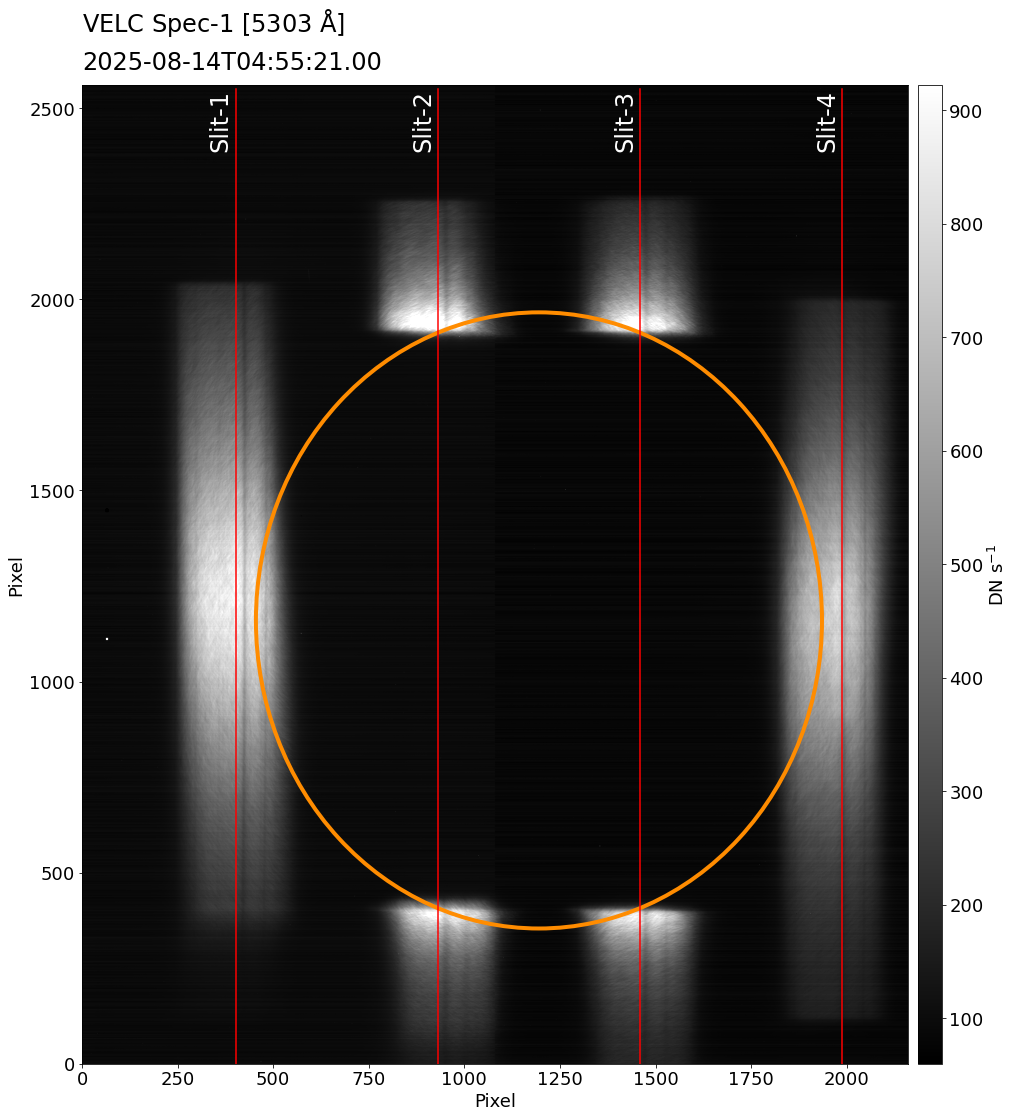

In [2]:
%matplotlib inline
fn = glob.glob('Data/20250813/VS1_T25_1190_002570_20250813_*.fits')
fn = np.sort(fn)
ii = 51

print(np.shape(fn))

dark = fits.getdata('Spec1_ground_dark_exp_2sec.fits')

#steps = int(len(fn))

hdul = fits.open(fn[ii])
im = hdul[0].data-dark
hdr = hdul[0].header

#hdr['date'][0:22]
sz=np.shape(im)

fig = plt.figure(figsize=(18, 18))
plt.rcParams.update({'font.size': 18})
ax = plt.gca()
im = im/float(hdr['EXPTIME'])
pim1 = plt.imshow(im,origin='lower',vmin=np.percentile(im,0.1),vmax=np.percentile(im,99.9),cmap='gist_gray')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
cb=plt.colorbar(pim1,pad=0.01,aspect=40)
cb.set_label(r'DN s$^{-1}$')
ellipse = patches.Ellipse(
        (1195+(51-ii)*5.66,1160), 
        1481, 
        1612, 
        angle=0, 
        edgecolor='darkorange', 
        facecolor='none', 
        linewidth=4)
ax.add_patch(ellipse)
plt.plot((402,402),(0,2550),color='red')
plt.plot((931,931),(0,2550),color='red')
plt.plot((1460,1460),(0,2550),color='red')
plt.plot((1989,1989),(0,2550),color='red')
plt.text(330,2400,'Slit-1', rotation=90,color='white',fontsize=24)
plt.text(860,2400,'Slit-2', rotation=90,color='white',fontsize=24)
plt.text(1390,2400,'Slit-3', rotation=90,color='white',fontsize=24)
plt.text(1919,2400,'Slit-4', rotation=90,color='white',fontsize=24)
plt.text(0,2700,r'VELC Spec-1 [5303$~\mathrm{\AA}$]',fontsize=24)
plt.text(0,2600,hdr['date'][0:22],fontsize=24)
plt.ylim(0,sz[0])
plt.xlim(0,sz[1])

[-919.5 -899.  -878.5 -858.5 -838.5 -818.5 -798.5 -778.5 -758.5 -738.5
 -718.5 -698.5 -678.5 -659.  -638.5 -619.  -599.  -578.5 -558.5 -538.5
 -519.  -498.5 -479.  -458.5 -438.5 -418.5 -398.5 -378.5 -358.5 -338.5
 -318.5 -299.  -278.5 -258.5 -238.5 -218.5 -198.5 -178.5 -158.5 -138.5
 -118.5  -98.5  -78.5  -58.5  -38.5  -18.5    1.5   21.5   41.5   61.
   81.5  101.5  121.5  141.5  161.5  181.5  201.   221.   241.5  261.
  281.5  301.5  321.5  341.   361.   381.   401.   421.   441.   461.
  481.   501.   521.   541.   561.   581.   601.5  621.5  641.5  661.5
  681.5  701.5  721.5  741.5  761.   781.5  801.5  821.5  841.   861.5
  881.5  901.5  921.5  941.5]


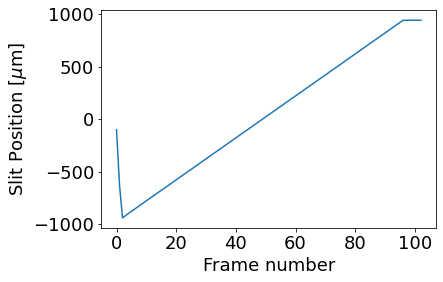

In [3]:
steps = int(len(fn))
#print(np.shape(fn))
hdul = fits.open(fn[0])
im = hdul[0].data
hdr = hdul[0].header

slit_pos = np.zeros(len(fn)) 
#print(np.shape(slit_pos))
for ii in range(len(fn)):
    hdul = fits.open(fn[ii])
    hdr = hdul[0].header
    slit_pos[ii] = hdr['SLIT_POS']
    
plt.plot(slit_pos)
plt.xlabel('Frame number')
plt.ylabel('Slit Position [$\mu$m]')

dstep = slit_pos[1:]-slit_pos[0:-1]
mstep = np.median(dstep)

ss = np.where((dstep > mstep-10) & (dstep < mstep+10))
ss[0][:]=ss[0][:]+1

nfn = fn[ss[0][0]:ss[0][0]+94]
sz = np.shape(im)
nslit_pos = slit_pos[ss[0][0]:ss[0][0]+94]
print(nslit_pos)

(0.0, 2160.0)

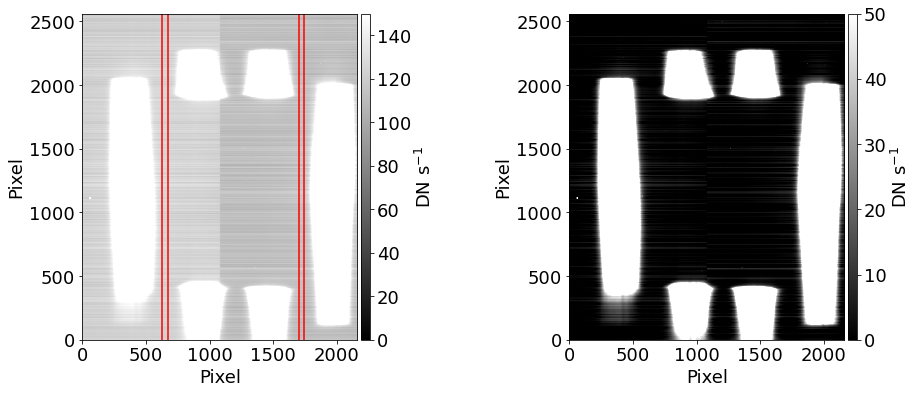

In [4]:
fig = plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 18})
ax = plt.gca()
nim = im/float(hdr['EXPTIME'])
cim = np.zeros(sz)
cim[:,0:int(sz[1]/2)]= nim[:,0:int(sz[1]/2)]-np.mean(nim[:,630:670])
cim[:,int(sz[1]/2):-1]= nim[:,int(sz[1]/2):-1]-np.mean(nim[:,1700:1740])

plt.subplot(1,2,1)
pim1 = plt.imshow(nim,origin='lower',vmin=0,vmax=150,cmap='gist_gray')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
cb=plt.colorbar(pim1,pad=0.01,aspect=40)
cb.set_label(r'DN s$^{-1}$')
plt.ylim(0,sz[0])
plt.xlim(0,sz[1])
plt.plot((630,630),(0,sz[0]),color='red')
plt.plot((670,670),(0,sz[0]),color='red')
plt.plot((1700,1700),(0,sz[0]),color='red')
plt.plot((1740,1740),(0,sz[0]),color='red')

plt.subplot(1,2,2)
pim1 = plt.imshow(cim,origin='lower',vmin=0,vmax=50,cmap='gist_gray')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
cb=plt.colorbar(pim1,pad=0.01,aspect=40)
cb.set_label(r'DN s$^{-1}$')
plt.ylim(0,sz[0])
plt.xlim(0,sz[1])

In [6]:
tspec = np.zeros([sz[0],sz[1],len(nfn)])

for ii in tqdm(range(len(nfn))): 
    hdul = fits.open(nfn[ii])

    hdr = hdul[0].header
    im = hdul[0].data/float(hdr['EXPTIME'])
    
    im[:,0:int(sz[1]/2)]= im[:,0:int(sz[1]/2)]-np.mean(im[:,630:670])
    im[:,int(sz[1]/2):-1]= im[:,int(sz[1]/2):-1]-np.mean(im[:,1700:1740])
    
    tspec[:,:,ii] = np.flip(im,1) 

100%|████████████████████████████████████████████| 94/94 [00:05<00:00, 17.80it/s]


In [7]:
wlm1 = 0
wlm2 = 518
wlm3 = 1040
wlm4 = 1566

scube = np.zeros((np.shape(tspec)[0],480,np.shape(tspec)[2]*4))

for ii in tqdm(range(np.shape(tspec)[2])):
    scube[:,:,ii] = tspec[:,wlm4:wlm4+480,ii]
    scube[:,:,ii+np.shape(tspec)[2]] = tspec[:,wlm3:wlm3+480,ii]
    scube[:,:,ii+np.shape(tspec)[2]*2] = tspec[:,wlm2:wlm2+480,ii]
    scube[:,:,ii+np.shape(tspec)[2]*3] = tspec[:,wlm1:wlm1+480,ii]
    
scube = np.transpose(scube,(0,2,1))

100%|████████████████████████████████████████████| 94/94 [00:08<00:00, 10.94it/s]


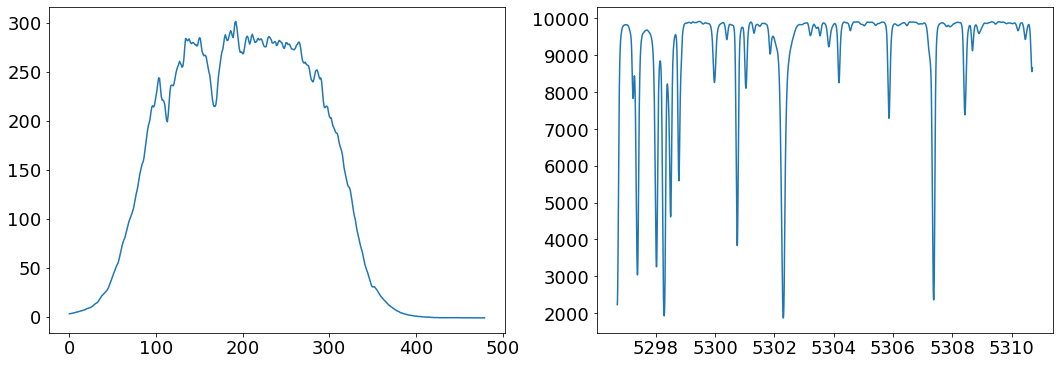

In [8]:
fl_fts = readsav('5303_fts.sav')
fts = fl_fts('aa')[0][0]

fig = plt.figure(figsize=(18, 6))
plt.rcParams.update({'font.size': 18})
ax = plt.gca()

plt.subplot(1,2,2)
plt.plot(fts[350:-150,0],fts[350:-150,1])
plt.subplot(1,2,1)
plt.plot(np.mean(scube[1150:1170,20:25,:],axis=(0,1)))

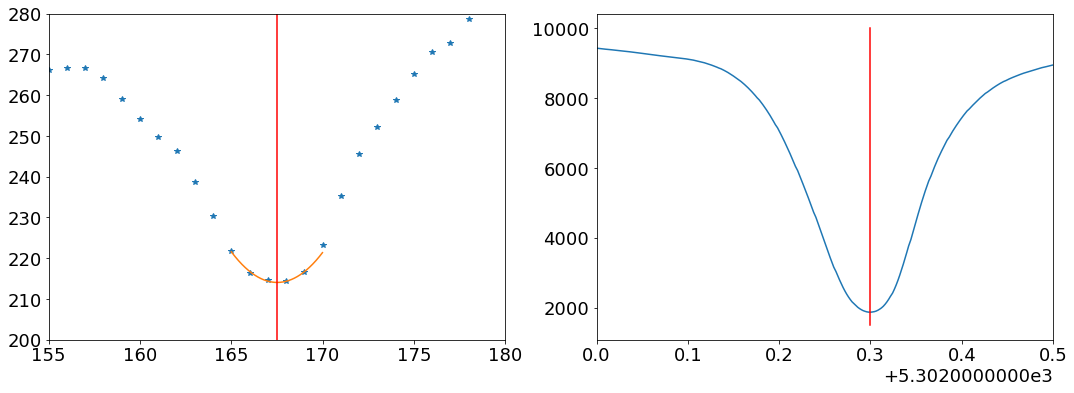

In [10]:
fig = plt.figure(figsize=(18, 6))
plt.rcParams.update({'font.size': 18})
ax = plt.gca()
xarr = np.arange(0,5,1)
nxarr = np.arange(0,500,1)/100
oprof = np.mean(scube[1150:1170,20:25,:],axis=(0,1))
mpos  = np.argmin(oprof[155:180])

zz = np.polyfit(xarr,oprof[155+mpos-3:155+mpos+2], 2)
nprof2 = (nxarr**2)*zz[0]+nxarr*zz[1]+zz[2]
wpos = np.argmin(nprof2)/100 + 165

plt.subplot(1,2,2)
# plt.plot(fts[350:-150,0],fts[350:-150,1])
plt.plot(fts[:,0],fts[:,1])
mind = np.argmin(fts[3000:3350,1])
plt.plot((fts[3000+mind,0],fts[3000+mind,0]),(1500,10000),color='red')
plt.xlim(5302,5302.5)

plt.subplot(1,2,1)
plt.plot(np.mean(scube[1150:1170,20:25,:],axis=(0,1)),'*')
plt.plot(nxarr+165,nprof2)
plt.plot((wpos,wpos),(0,500),color='red')
plt.xlim(155,180)
plt.ylim(200,280)

lam = (np.arange(0,480,1)-wpos)*0.0284+fts[3000+mind,0]
#print(wav)

Text(0.5, 0, '$\\lambda~[\\mathrm{\\AA}]$')

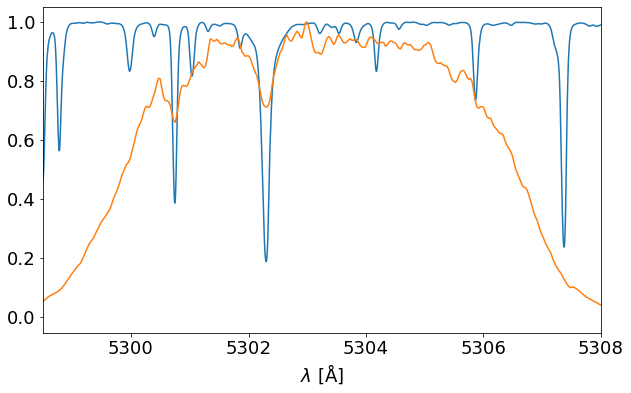

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
ax = plt.gca()
plt.plot(fts[:,0],fts[:,1]/np.max(fts[:,1]))
plt.plot(lam,oprof/np.max(oprof))
plt.xlim(5298.5,5308)
plt.xlabel(r'$\lambda~[\mathrm{\AA}]$')

In [12]:
ssz = np.shape(scube)

imap = np.mean(scube,axis=2)
backv = np.mean(imap[750:1650,120:275])
mask = np.zeros(imap.shape)
#mask[np.where(imap >=backv*10)] = 1
mask[np.where(imap >= 30)] = 1
mask[0:1,:] = 0

shifta = np.zeros((ssz[0],ssz[1]))
shiftb = np.zeros((ssz[0],ssz[1]))
#prof1 = np.mean(scube[1280-2:1280+2,60,170:187],axis=0)
#prof1 = prof1/np.max(prof1)

for ii in tqdm(range(1,ssz[0]-1)):
    for jj in range(ssz[1]):
        prof2 = np.mean(scube[ii-1:ii+1,jj,150:200],axis=0)
        mpos = np.argmin(prof2)
        shiftb[ii,jj] = mpos
        xarr = np.arange(0,9,1)
        nxarr = np.arange(0,900,1)/100
        
        if (mpos > 8) and (mpos < 41): 
            zz = np.polyfit(xarr, prof2[mpos-4:mpos+5], 2)
            nprof2 = (nxarr**2)*zz[0]+nxarr*zz[1]+zz[2]
            shifta[ii,jj] = np.argmin(nprof2)/100 + shiftb[ii,jj]-7

100%|████████████████████████████████████████| 2558/2558 [00:35<00:00, 71.86it/s]


Text(0, 0.5, 'Wavelenght offset [$\\rm{m\\AA}$]')

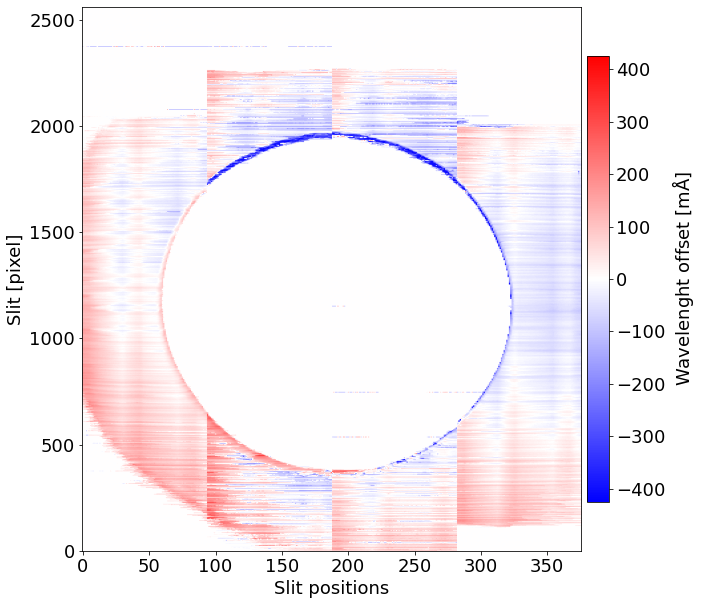

In [13]:
fig = plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 18})
shifta = (shifta-np.mean(shifta[1150:1170,20:25]))*mask
im1=plt.imshow(shifta*28.4,aspect=0.16,origin='lower',vmin=-15*28.4,vmax=15*28.4,cmap='bwr')
plt.xlabel('Slit positions')
plt.ylabel('Slit [pixel]')
cbar=plt.colorbar(im1,fraction=0.04, pad=0.01)
cbar.ax.set_ylabel(r'Wavelenght offset [$\rm{m\AA}$]')

In [14]:
nscube = np.zeros(ssz)

for ii in tqdm(range(ssz[0])):
    for jj in range(ssz[1]):
        prof = scube[ii, jj, :]
        nscube[ii,jj,:] = ndimage.shift(prof, -1*shifta[ii,jj],order=3, mode='grid-wrap')

100%|████████████████████████████████████████| 2560/2560 [00:46<00:00, 54.57it/s]


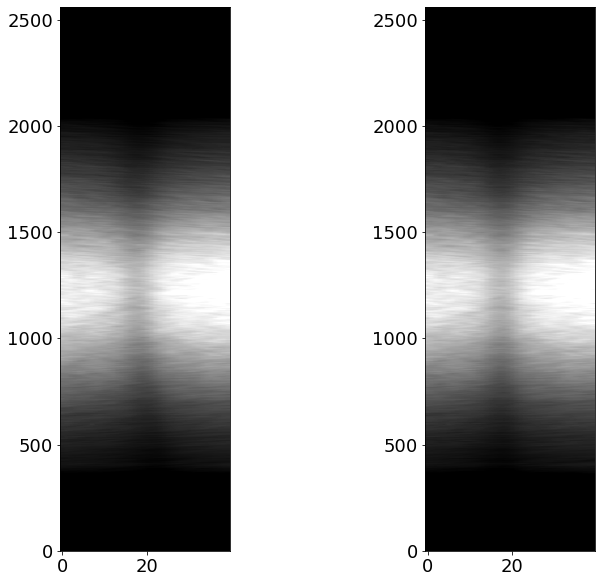

In [15]:
fig = plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': 18})

plt.subplot(1,2,1)
nor1 = np.mean(scube[:,50,150:155],axis=1)
plt.imshow(scube[:,50,150:190],origin="lower",cmap='gist_gray',aspect=0.05,vmin=100,vmax=850)
plt.subplot(1,2,2)
nor2 = np.mean(nscube[:,50,150:155],axis=1)
plt.imshow(nscube[:,50,150:190],origin="lower",cmap='gist_gray',aspect=0.05,vmin=100,vmax=850)


In [16]:
def get_spatial_image(wav):
    #global wav
    #img = np.squeeze(spec[:,:,wav]-blev)
    img = np.squeeze(nscube[:,:,wav])
    return img

def get_spectral_image(posx):
    #aa = blev[:,posx]
#     simg  = np.squeeze(spec[:,posx,:]- aa[:,np.newaxis])
    simg  = np.squeeze(nscube[:,posx,:])#- aa[:,np.newaxis])
    return simg

def get_profiles(posy,posx):
    #global posx, posy
    #pobs = np.squeeze(obs[posy,posx,:])
    #pspec = np.squeeze(spec[posy,posx,:])
    pback = np.squeeze(nscube[posy,posx,:])
    return pback    

In [17]:
%matplotlib qt5
size = plt.rcParams['lines.markersize']

wav = 190
posx = 60
posy = 850
#posx = (60-sz[1]/2)*40*1.25/6.5
#posy = (850-1160)*1.25

print(posx,posy)
fig = plt.figure(figsize=(18, 8))
plt.rcParams.update({'font.size': 12})
gs1 = gridspec.GridSpec(1, 1, figure=fig)
gs2 = gridspec.GridSpec(1, 1, figure=fig)
gs3 = gridspec.GridSpec(1, 1, figure=fig)
gs1.update(left=0.05, right=0.33, bottom=0.1,top=0.9)
gs2.update(left=0.4, right=0.6, bottom=0.1,top=0.9)
gs3.update(left=0.65, right=0.95, bottom=0.2,top=0.8)
#fig, axs = plt.subplots(1, 3, figsize=(24, 8))

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs2[0, 0])
ax3 = fig.add_subplot(gs3[0, 0])

im00a = ax1.imshow(get_spatial_image(wav), aspect=1,
                      extent = [(-ssz[1]/2)*40*1.25/6.5,(ssz[1]/2)*40*1.25/6.5,-1160*1.25,(ssz[0]-1160)*1.25],
                      vmax=np.percentile(get_spatial_image(wav),99.5),
                      cmap='gist_gray', origin='lower')
im00b, = ax1.plot([(posx-sz[1]/2)*40*1.25/6.5,(posx-sz[1]/2)*40*1.25/6.5],[-1160*1.25,(ssz[0]-1160)*1.25],color='red')
im00c, = ax1.plot([-1160*1.25,(ssz[0]-1160)*1.25],[(posy-sz[1]/2)*40*1.25/6.5,(posy-sz[1]/2)*40*1.25/6.5],color='red')
ax1.set_ylabel('Solar-Y [arcsec]')
ax1.set_xlabel('Solar-X [arcsec]')

#print(posy,(posy-1160)*1.125))
im01a = ax2.imshow(get_spectral_image(posx), aspect=0.01, 
                      extent = [lam[0],lam[-1],-1160*1.25,(ssz[0]-1160)*1.25],
                      vmax=np.percentile(get_spectral_image(posx),99.5),
                      cmap='gist_gray', origin='lower')
im01b, = ax2.plot([lam[0],lam[100]],[(posy-1160)*1.125,(posy-1160)*1.125], color='red')
im01c, = ax2.plot([lam[ssz[2]-100],lam[ssz[2]-1]],[(posy-1160)*1.125,(posy-1160)*1.125], color='red')
ax2.set_ylabel('Solar-Y [arcsec]')
ax2.set_xlabel(r'[$\rm{\AA}$]')
#paa, pbb, pcc = get_profiles(posy,posx)
pcc = get_profiles(posy,posx)

smax = np.max(pcc)
p02d, = ax3.plot([wav,wav],[-50,smax+100],color='gray')
# p02a, = axs[2].plot(paa,color='k')
# p02b, = axs[2].plot(pbb,color='green')
p02c, = ax3.plot(pcc,color='blue')
ax3.set_ylabel(r'DN s$^{-1}$')
ax3.set_xlabel(r'Wavelength [$\rm{\AA}$]')

# axs[1][0].set_ylim(0.35, 0.8)
ax1.set_ylim(-1160*1.25,(ssz[0]-1160)*1.25)
ax1.set_xlim((-ssz[1]/2)*40*1.25/6.5,(ssz[1]/2)*40*1.25/6.5)

ax2.set_ylim(-1160*1.25,(ssz[0]-1160)*1.25)
ax2.set_xlim(lam[0],lam[-1])

#axs[2].set_ylim(-50,smax+100)
ax3.set_xlim(0,ssz[2])

xx = [posx]
yy = [posy]

wav_axs = plt.axes([0.125, 0.94, 0.23, 0.03])

def update_wav(val):
    global wav
    wav = val
    dd = get_spatial_image(wav)
    im00a.set_data(dd)
    p02d.set_xdata([wav,wav])
    fig.canvas.draw_idle()
    
def on_click_event(event):
    global posx, posy, xx, yy
    ax = event.inaxes

    if ax is None or ax != ax1:
        return
    
    posx = np.round(event.xdata, 0).astype(np.int64)
    posy = np.round(event.ydata, 0).astype(np.int64)  
    
    xmin = np.asarray((-ssz[1]/2)*40*1.25/6.5)
    xmax = np.asarray((ssz[1]/2)*40*1.25/6.5)
    ymin = np.asarray(-1160*1.25)
    ymax = np.asarray((ssz[0]-1160)*1.25)
    
    xx = int((np.asarray(posx)-xmin)/((xmax-xmin)/ssz[1]))
    yy = int((np.asarray(posy)-ymin)/((ymax-ymin)/ssz[0]))
    
#    print(posx,posy,xx,yy)

    im00b.set_xdata([(np.asarray(xx)-ssz[1]/2)*40*1.25/6.5,(np.asarray(xx)-ssz[1]/2)*40*1.25/6.5])
    im00c.set_ydata([(np.asarray(yy)-1160)*1.25,(np.asarray(yy)-1160)*1.25])
    
#    im00b.set_xdata([xx,xx])
#    im00c.set_ydata([yy,yy])
            
    dd = get_spectral_image(xx)
    im01a.set_data(dd)
    
    #im01b.set_ydata([yy,yy])
    #im01c.set_ydata([yy,yy])
    
    im01b.set_ydata([(np.asarray(yy)-1160)*1.25,(np.asarray(yy)-1160)*1.25])
    im01c.set_ydata([(np.asarray(yy)-1160)*1.25,(np.asarray(yy)-1160)*1.25])
    
    #pa, pb, pc = get_profiles(yy,xx)
    pc = get_profiles(yy,xx)  
    
    p02c.set_ydata(pc)
    p02d.set_ydata([-50,np.max(pc)+200])
    
    ax3.set_ylim(-50,np.max(pc)+200)
    fig.canvas.draw_idle()

wave_slider = Slider(
    ax=wav_axs,
    label='Wavelength position',
    valmin=10,
    valmax=470,
    valinit=190,
    valstep=1
)

wave_slider.on_changed(update_wav)

fig.canvas.mpl_connect('button_press_event', on_click_event)

plt.show()

60 850
